#   Avaliação de hipótese 1:

Aqui vamos avaliar o impacto da "brand" para o nosso modelo.

A razão de tal análize serve para entendermos melhor qual tratamento deveremos dar para nossos dados 632682 nulos, um número significativo dentro de nosso dataset. Para isso vamos separa-los em 2 datasets, um contendo apenas os valores nulos/missing e um outro dataset contendo todos as colinas preenchidas. Após essa etápa vamos gerar modelos probatórios para  um teste a/b, onde poderemos analisar o melhor caminho para o tratamento desses valores nulos.


In [1]:
import pandas as pd
import random 
import numpy as np
import re
from scipy.sparse import hstack

In [2]:
from pre_processamento import pre_processamento,text_preprocess

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

In [5]:
from lightgbm import LGBMRegressor

In [6]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

In [7]:
train = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\train.tsv", sep='\t')
test = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\test.tsv", sep='\t')

In [8]:
train,test = pre_processamento(train,test)

In [9]:
train.head()

,name,item_condition_id,brand_name,price,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_month,datetime_year
0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.0,1,No description yet,27,Men,Tops,T-shirts,6.0,2018.0
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,15,Electronics,Computers & Tablets,Components & Parts,3.0,2018.0
2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,14,Women,Tops & Blouses,Blouse,10.0,2018.0
3,Leather Horse Statues,1,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,1,Home,Home Décor,Home Décor Accents,3.0,2018.0
4,24K GOLD plated rose,1,NaN,44.0,0,Complete with certificate of authenticity,13,Women,Jewelry,Necklaces,5.0,2018.0


# Pré Processamento

In [10]:
train["name"] = train["name"].apply(lambda x: text_preprocess(x)) #limpeza do texto na coluna name

In [11]:
train["item_description"] = train["item_description"].astype(str) 

In [12]:
train["item_description"] = train["item_description"].apply(lambda x: text_preprocess(x)) #limpeza do texto na coluna de descrição

#   Modelo com brands não nulas.


In [13]:
Train_with_brand = train.dropna(subset="brand_name") #Dropando todas as linhas nulas  em brand,nesse modelo só teremos valores não nulos para essa coluna

In [14]:
Train_with_brand=Train_with_brand.sample(632682) #igualando ao numero de samples do dataset de brands nulas.

In [15]:
print(Train_with_brand.shape)

Train_with_brand.head()

(632682, 12)


,name,item_condition_id,brand_name,price,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_month,datetime_year
1020610,too faced born this way foundation,1,Too Faced,16.0,1,25 samples shade natural beige,1,Beauty,Makeup,Face,4.0,2018.0
73445,bbw seasonal pumpkin mini candles,1,Bath & Body Works,16.0,0,brand new never burnt this includes all 4 cand...,4,Beauty,Fragrance,Candles & Home Scents,6.0,2018.0
424768,skull jacket bundle,1,Children's Place,25.0,0,adorable skull hoodies the mohawk one is adora...,13,Kids,Boys 0-24 Mos,Coats & Jackets,3.0,2018.0
534786,xs s m l or xl nike pro capris nwt,1,Nike,31.0,0,nike pro capris size xs s m l or xl nwt price ...,2,Women,Athletic Apparel,"Pants, Tights, Leggings",2.0,2018.0
169475,kendra scott gunmetal camilla,3,Kendra Scott,45.0,1,excellent condition comes in kendra scott dust...,4,Women,Jewelry,Necklaces,1.0,2018.0


In [16]:
X1 = Train_with_brand.drop("price", axis = 1)
y1 = Train_with_brand["price"]

In [17]:
X1train, X1val, y1train, y1val = train_test_split(X1, y1, test_size=0.3, random_state=10) #split 70/30 

<AxesSubplot:>

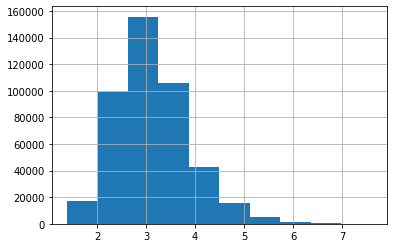

In [18]:
#Normalizando, com log, o target (price), foi realizado de forma separada para nao terem dados vazados.

y1train =  np.log1p(y1train)
y1val =  np.log1p(y1val)
y1train.hist()

-   dados de treino.

In [19]:
vec1 = TfidfVectorizer(stop_words='english', ngram_range=(1,1), max_features=50000) #remoção de stopword e max features criadas em 50000

vce_xtrain_name_1 = vec1.fit_transform(X1train["name"])
vce_xtrain_descrip_1 = vec1.fit_transform(X1train["item_description"])

In [20]:
#aplicação dummy nas colunas categóricas.

ohe1 = OneHotEncoder(handle_unknown="ignore")

ohe1_train = ohe1.fit_transform(X1train[["item_condition_id",   
                                         "shipping",
                                         "brand_name",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                         "datetime_month"]])

In [21]:
x1_train = hstack([                                #função para juntar as matrizes criadas
                  (vce_xtrain_name_1),
                  (vce_xtrain_descrip_1),
                  (ohe1_train)  
                        ])

In [22]:
x1_train

<442877x104793 sparse matrix of type '<class 'numpy.float64'>'
	with 10518502 stored elements in Compressed Sparse Row format>

In [23]:
lgb1 = LGBMRegressor(device = "gpu", learning_rate=0.5)

In [24]:
model1 = lgb1.fit(x1_train, y1train)  

-   dados de validação.

In [25]:
#Aplicando transformações nos dados de validação


vce_xval_name_1 = vec1.transform(X1val["name"])
vce_xval_descrip_1 = vec1.transform(X1val["item_description"])

ohe_val_condition_1 = ohe1.transform(X1val[["item_condition_id",   
                                          "shipping",
                                          "brand_name",
                                          "gen_cat",
                                          "sub1_cat",
                                          "sub2_cat", 
                                          "datetime_month"]])

x_val1 = hstack([(vce_xval_name_1),
                (vce_xval_descrip_1), 
                (ohe_val_condition_1)])



In [26]:
x_val1

<189805x104793 sparse matrix of type '<class 'numpy.float64'>'
	with 4480071 stored elements in Compressed Sparse Row format>

In [27]:
p1 = model1.predict(x_val1)

In [28]:
y1predict = np.expm1(p1)
y1val =np.expm1(y1val)

# Dataset com Brand nulas

In [29]:
train_No_brand = train.loc[train.brand_name.isnull()] #Separando todas as linhas nulas  em brand,nesse modelo só teremos valores nulos para essa coluna

In [30]:
X2 = train_No_brand.drop("price", axis = 1)
y2 = train_No_brand["price"]

In [31]:
X2train, X2val, y2train, y2val = train_test_split(X2, y2, test_size=0.3, random_state=10)

<AxesSubplot:>

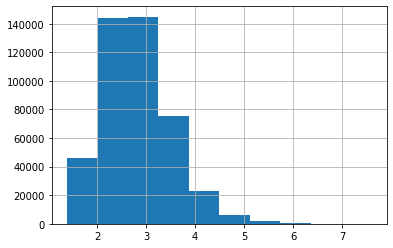

In [32]:
y2train =  np.log1p(y2train)
y2val =  np.log1p(y2val)
y2train.hist()

In [33]:
vec2 = TfidfVectorizer(stop_words='english', ngram_range=(1,1), max_features=50000)

vce_xtrain_name_2 = vec2.fit_transform(X2train["name"])
vce_xtrain_descrip_2 = vec2.fit_transform(X2train["item_description"])

#aplicação dummy nas colunas categóricas.

ohe2 = OneHotEncoder(handle_unknown="ignore")

ohe2_train = ohe2.fit_transform(X2train[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                         "datetime_month"]])

In [34]:
x2_train = hstack([
                  (vce_xtrain_name_2),
                  (vce_xtrain_descrip_2),
                  (ohe2_train)  
                        ])

In [35]:
x2_train

<442635x100985 sparse matrix of type '<class 'numpy.float64'>'
	with 11365850 stored elements in Compressed Sparse Row format>

In [36]:
lgb2 = LGBMRegressor(device = "gpu", learning_rate=0.5)

In [37]:
model2 = lgb2.fit(x2_train, y2train)

In [38]:

vce_xval_name_2 = vec2.transform(X2val["name"])
vce_xval_descrip_2 = vec2.transform(X2val["item_description"])

ohe_val_condition_2 = ohe2.transform(X2val[["item_condition_id",   
                                          "shipping",
                                          "gen_cat",
                                          "sub1_cat",
                                          "sub2_cat", 
                                          "datetime_month"]])

x_val2 = hstack([(vce_xval_name_2),
                (vce_xval_descrip_2), 
                (ohe_val_condition_2)])


In [39]:
x_val2

<189701x100985 sparse matrix of type '<class 'numpy.float64'>'
	with 4846681 stored elements in Compressed Sparse Row format>

In [40]:
p2 = model2.predict(x_val2)

In [41]:
y2predict = np.expm1(p2)
y2val =np.expm1(y2val)

#   Resultados

In [42]:
print("---------------Modelo com brand----------------- ")


print('MAE: %2f' % mean_absolute_error(y1val,y1predict))
print('RMSE: %2f' % (mean_squared_error(y1val,y1predict)))

---------------Modelo com brand----------------- 
MAE: 13.470141
RMSE: 1266.732524


In [43]:
print("---------------Modelo sem brand----------------- ")


print('MAE: %2f' % mean_absolute_error(y2val,y2predict))
print('RMSE: %2f' % (mean_squared_error(y2val,y2predict)))

---------------Modelo sem brand----------------- 
MAE: 10.244517
RMSE: 624.229604


# Conclusão

Conforme levantado na hipótese, verificariamos o quão explicativo a brand é no atual projeto, para saber como tratar tantos valores nulos, aproximadamente42%. O objetivo não foi alcançar a melhor métrica, apenas comparar em condições similares.

Na preparação do treino/teste foi utilizado o mesmo sample de dados, pré processamento, tratamento e parâmetros de modelo, no caso o lightgbm.

obtendo os resultados :

---------------Modelo com brand----------------- 

MAE: 13.470141

RMSE: 1266.732524

---------------Modelo sem brand----------------- 

MAE: 10.244517

RMSE: 624.229604



Podemos observar que com as brands o modelo perde em ambas as métricas, isso pode ser devido ao grande desbalanceamento entre as marcas.

Contudo, essas informções de brand não serão descartadas.